In [1]:
import os
import shutil
import random
import itertools
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib as mpl
from keras import backend
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from keras.applications import imagenet_utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, Activation
from sklearn.metrics import precision_score, recall_score
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import decode_predictions, preprocess_input
from tensorflow.keras.metrics import Precision, Recall

# InceptionV3 Base-model

In [32]:
labels = ['Flooding', 'No Flooding']
train_path = 'MobileNet-CNN/data/train'
valid_path = 'MobileNet-CNN/data/valid'
test_path = 'MobileNet-CNN/data/test'

datagen = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images up to 40 degrees
    width_shift_range=0.2,  # Shift images horizontally by up to 20% of their width
    height_shift_range=0.2,  # Shift images vertically by up to 20% of their height
    shear_range=0.2,  # Randomly shear images
    zoom_range=0.2,  # Randomly zoom images
    horizontal_flip=True,  # Flip images horizontally
    fill_mode='nearest',  # Fill in empty pixels during transformations
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input
)

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 281 images belonging to 2 classes.
Found 67 images belonging to 2 classes.
Found 67 images belonging to 2 classes.


In [35]:
inception = tf.keras.applications.InceptionV3(input_shape=(224, 224, 3),include_top=False,weights='imagenet')

In [36]:
for layer in inception.layers:
  layer.trainable = False

In [37]:
x = inception.output
x = keras.layers.GlobalAveragePooling2D()(x)
output = Dense(units=2, activation='sigmoid')(x)

In [38]:
imodel = Model(inputs=inception.input, outputs=output)

In [39]:
imodel.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


In [40]:
ihist = imodel.fit(x=train_batches,
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          epochs=12,
          verbose=2
)

Epoch 1/12
29/29 - 5s - loss: 0.7589 - accuracy: 0.5338 - val_loss: 0.6412 - val_accuracy: 0.5970
Epoch 2/12
29/29 - 4s - loss: 0.6194 - accuracy: 0.6690 - val_loss: 0.5774 - val_accuracy: 0.6866
Epoch 3/12
29/29 - 4s - loss: 0.5452 - accuracy: 0.7402 - val_loss: 0.5279 - val_accuracy: 0.7612
Epoch 4/12
29/29 - 4s - loss: 0.4850 - accuracy: 0.8043 - val_loss: 0.4851 - val_accuracy: 0.7910
Epoch 5/12
29/29 - 4s - loss: 0.4380 - accuracy: 0.8612 - val_loss: 0.4505 - val_accuracy: 0.7910
Epoch 6/12
29/29 - 4s - loss: 0.3995 - accuracy: 0.8719 - val_loss: 0.4232 - val_accuracy: 0.8507
Epoch 7/12
29/29 - 4s - loss: 0.3616 - accuracy: 0.9181 - val_loss: 0.3992 - val_accuracy: 0.8507
Epoch 8/12
29/29 - 4s - loss: 0.3337 - accuracy: 0.9359 - val_loss: 0.3772 - val_accuracy: 0.8806
Epoch 9/12
29/29 - 4s - loss: 0.3084 - accuracy: 0.9395 - val_loss: 0.3594 - val_accuracy: 0.8806
Epoch 10/12
29/29 - 4s - loss: 0.2895 - accuracy: 0.9395 - val_loss: 0.3454 - val_accuracy: 0.8657
Epoch 11/12
29/29 -

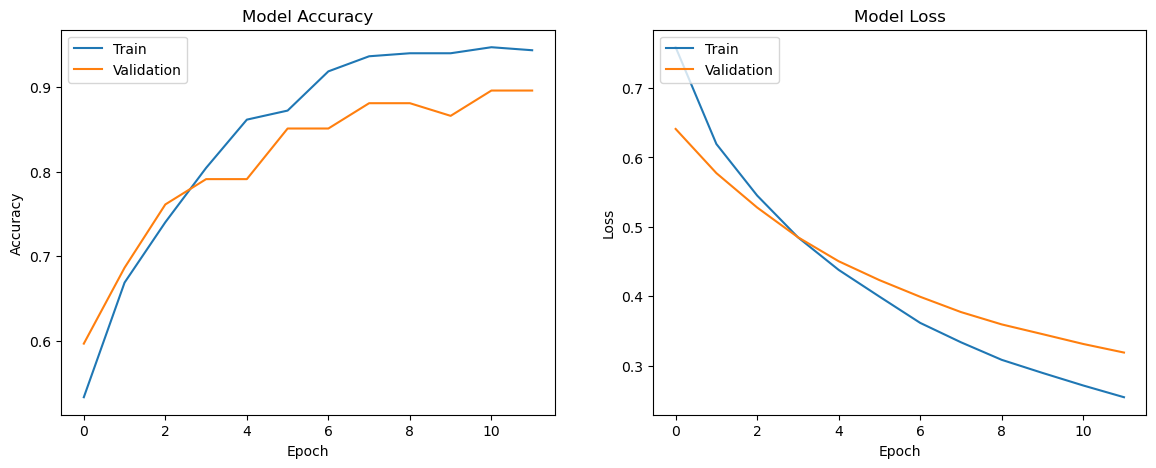

In [41]:
import matplotlib.pyplot as plt

# Fit the model and save the history


# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(ihist.history['accuracy'])
plt.plot(ihist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(ihist.history['loss'])
plt.plot(ihist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [47]:
from sklearn.metrics import f1_score

test_labels = test_batches.classes
predictions = imodel.predict(x=test_batches, steps=len(test_batches), verbose=0)
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))
precision = precision_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))
recall = recall_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))
f1_score = f1_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))
accuracy = accuracy_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [48]:
print('Precision: ', precision)
print('Recall: ', recall)
print('F1 Score: ', f1_score)
print('Accuracy: ', accuracy)

Precision:  0.9166666666666666
Recall:  0.9166666666666666
F1 Score:  0.9166666666666666
Accuracy:  0.9402985074626866


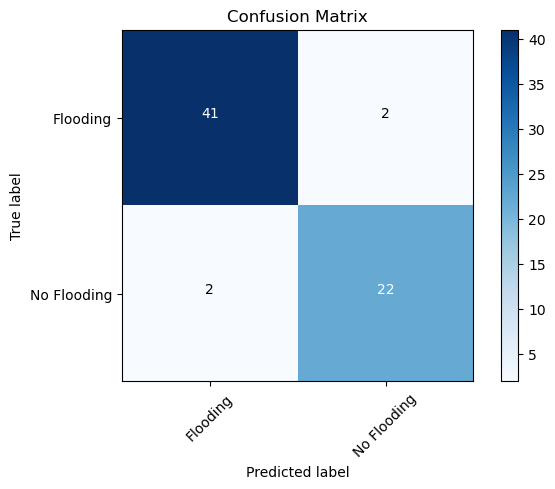

In [49]:
test_batches.class_indices
cm_plot_labels = ['Flooding','No Flooding']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

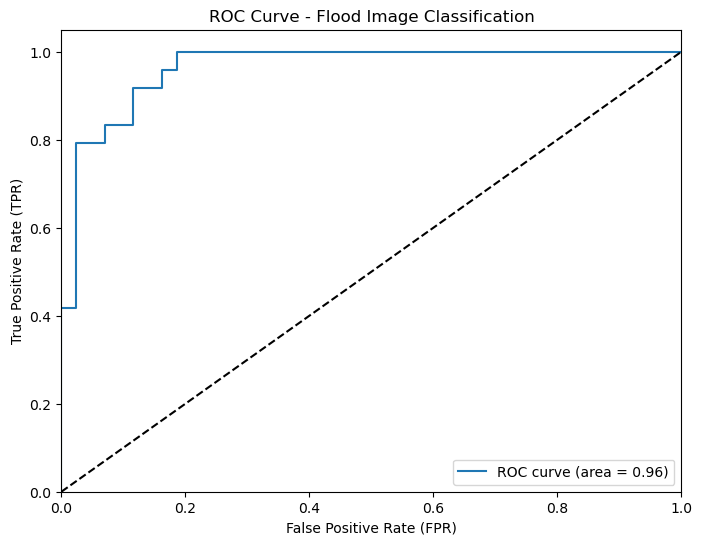

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


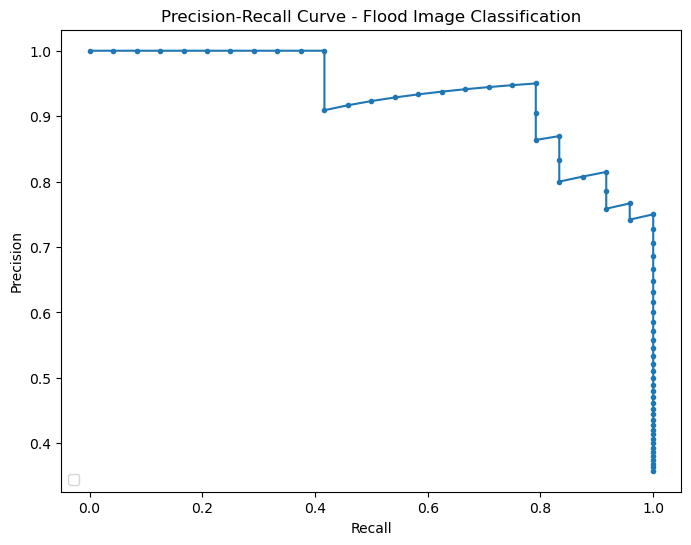

In [50]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Get true labels and predicted probabilities
test_labels = test_batches.classes
predictions = imodel.predict(x=test_batches, steps=len(test_batches), verbose=0)

# Calculate false positive rate (FPR) and true positive rate (TPR) for ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, predictions[:, 1])

# Calculate Area Under the Curve (AUC) for ROC curve
roc_auc = auc(fpr, tpr)

# Calculate precision and recall for different thresholds in Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(test_labels, predictions[:, 1])

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve - Flood Image Classification')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Flood Image Classification')
plt.legend(loc="lower left")
plt.show()


# InceptionV3

In [3]:
labels = ['Flooding', 'No Flooding']
train_path = 'MobileNet-CNN/data/train'
valid_path = 'MobileNet-CNN/data/valid'
test_path = 'MobileNet-CNN/data/test'

datagen = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images up to 40 degrees
    width_shift_range=0.2,  # Shift images horizontally by up to 20% of their width
    height_shift_range=0.2,  # Shift images vertically by up to 20% of their height
    shear_range=0.2,  # Randomly shear images
    zoom_range=0.2,  # Randomly zoom images
    horizontal_flip=True,  # Flip images horizontally
    fill_mode='nearest',  # Fill in empty pixels during transformations
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input
)

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 281 images belonging to 2 classes.
Found 67 images belonging to 2 classes.
Found 67 images belonging to 2 classes.


In [4]:
inception = tf.keras.applications.InceptionV3(input_shape=(224, 224, 3),include_top=False,weights='imagenet')

In [5]:
x = inception.get_layer('conv2d_60').output
x

<tf.Tensor 'conv2d_60/Conv2D:0' shape=(None, 12, 12, 192) dtype=float32>

In [6]:
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.3)(x)  # Regularize with dropout
output = Dense(units=2, activation='sigmoid')(x)

In [7]:
model = Model(inputs=inception.input, outputs=output)

In [8]:
for layer in model.layers[:-6]:
    layer.trainable = False

In [9]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


In [10]:
history = model.fit(x=train_batches,
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          epochs=20,
          verbose=2
)

Epoch 1/20
29/29 - 4s - loss: 0.6616 - accuracy: 0.6050 - val_loss: 0.5615 - val_accuracy: 0.6269
Epoch 2/20
29/29 - 3s - loss: 0.5643 - accuracy: 0.6940 - val_loss: 0.4863 - val_accuracy: 0.7910
Epoch 3/20
29/29 - 4s - loss: 0.5022 - accuracy: 0.8470 - val_loss: 0.4275 - val_accuracy: 0.8507
Epoch 4/20
29/29 - 3s - loss: 0.4292 - accuracy: 0.8897 - val_loss: 0.3824 - val_accuracy: 0.8806
Epoch 5/20
29/29 - 3s - loss: 0.3839 - accuracy: 0.8968 - val_loss: 0.3442 - val_accuracy: 0.9254
Epoch 6/20
29/29 - 4s - loss: 0.3342 - accuracy: 0.9502 - val_loss: 0.3155 - val_accuracy: 0.9552
Epoch 7/20
29/29 - 3s - loss: 0.3233 - accuracy: 0.9395 - val_loss: 0.2877 - val_accuracy: 0.9552
Epoch 8/20
29/29 - 3s - loss: 0.2838 - accuracy: 0.9395 - val_loss: 0.2668 - val_accuracy: 0.9552
Epoch 9/20
29/29 - 3s - loss: 0.2624 - accuracy: 0.9466 - val_loss: 0.2505 - val_accuracy: 0.9701
Epoch 10/20
29/29 - 3s - loss: 0.2429 - accuracy: 0.9537 - val_loss: 0.2378 - val_accuracy: 0.9254
Epoch 11/20
29/29 -

In [16]:
model.save('saved-model/inceptionV3-Modified.h5')

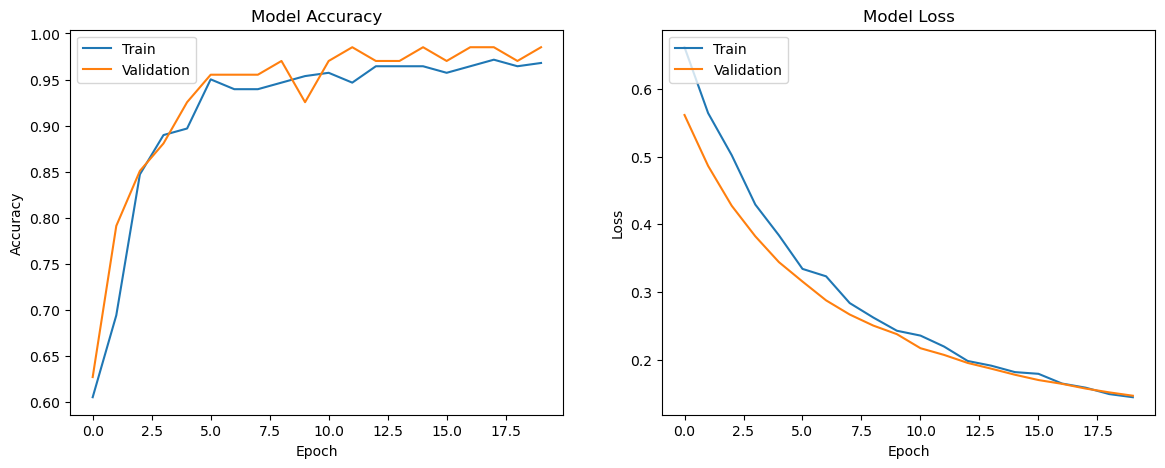

In [11]:
import matplotlib.pyplot as plt

# Fit the model and save the history


# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [12]:
from sklearn.metrics import f1_score

test_labels = test_batches.classes
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))
precision = precision_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))
recall = recall_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))
f1_score = f1_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))
accuracy = accuracy_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [13]:
print('Precision: ', precision)
print('Recall: ', recall)
print('F1 Score: ', f1_score)
print('Accuracy: ', accuracy)

Precision:  0.96
Recall:  1.0
F1 Score:  0.9795918367346939
Accuracy:  0.9850746268656716


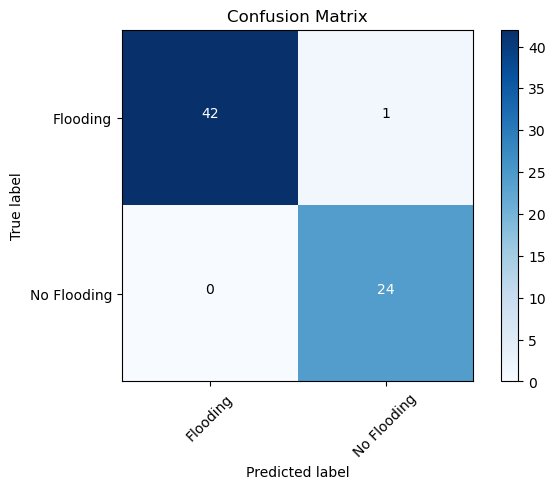

In [14]:
test_batches.class_indices
cm_plot_labels = ['Flooding','No Flooding']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

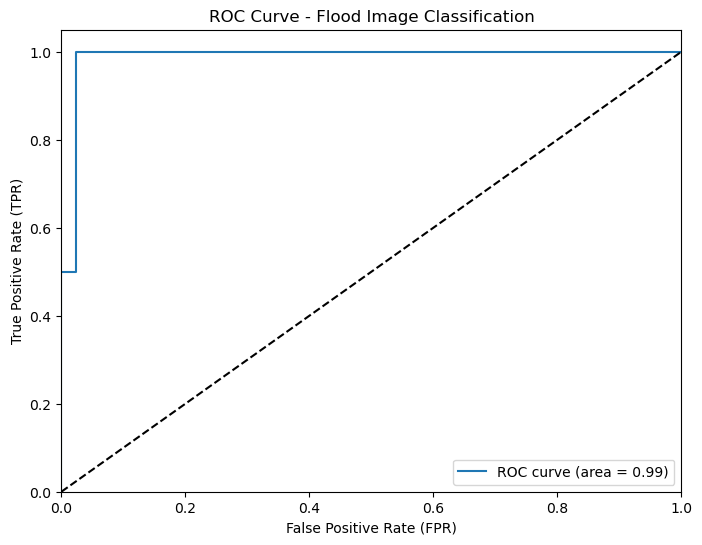

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


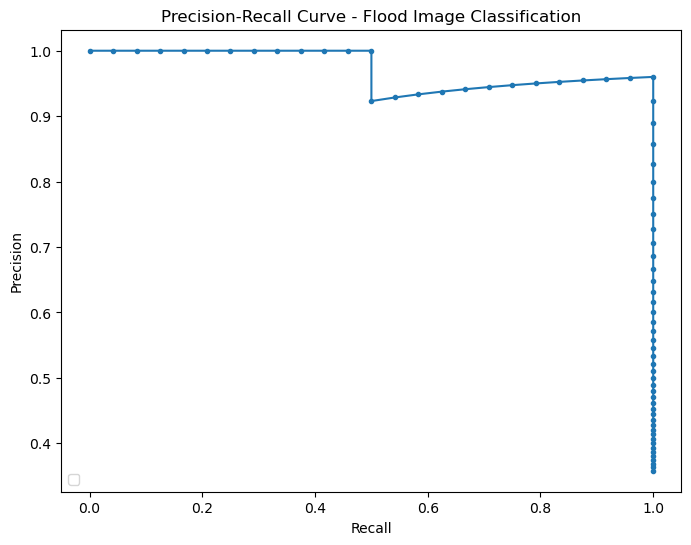

In [15]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Get true labels and predicted probabilities
test_labels = test_batches.classes
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

# Calculate false positive rate (FPR) and true positive rate (TPR) for ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, predictions[:, 1])

# Calculate Area Under the Curve (AUC) for ROC curve
roc_auc = auc(fpr, tpr)

# Calculate precision and recall for different thresholds in Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(test_labels, predictions[:, 1])

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve - Flood Image Classification')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Flood Image Classification')
plt.legend(loc="lower left")
plt.show()


In [17]:
def preprocess_image(file):
    img_path = ''
    img = image.load_img(img_path + file, target_size=(224, 224, 3))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.inception_v3.preprocess_input(img_array_expanded_dims)

In [18]:
from IPython.display import Image

def predict(file):
  preprocessed_image = preprocess_image(file)
  predictions = model.predict(preprocessed_image)
  result = np.argmax(predictions)
  print(labels[result])
  return Image(filename=file, width=300,height=200)

No Flooding


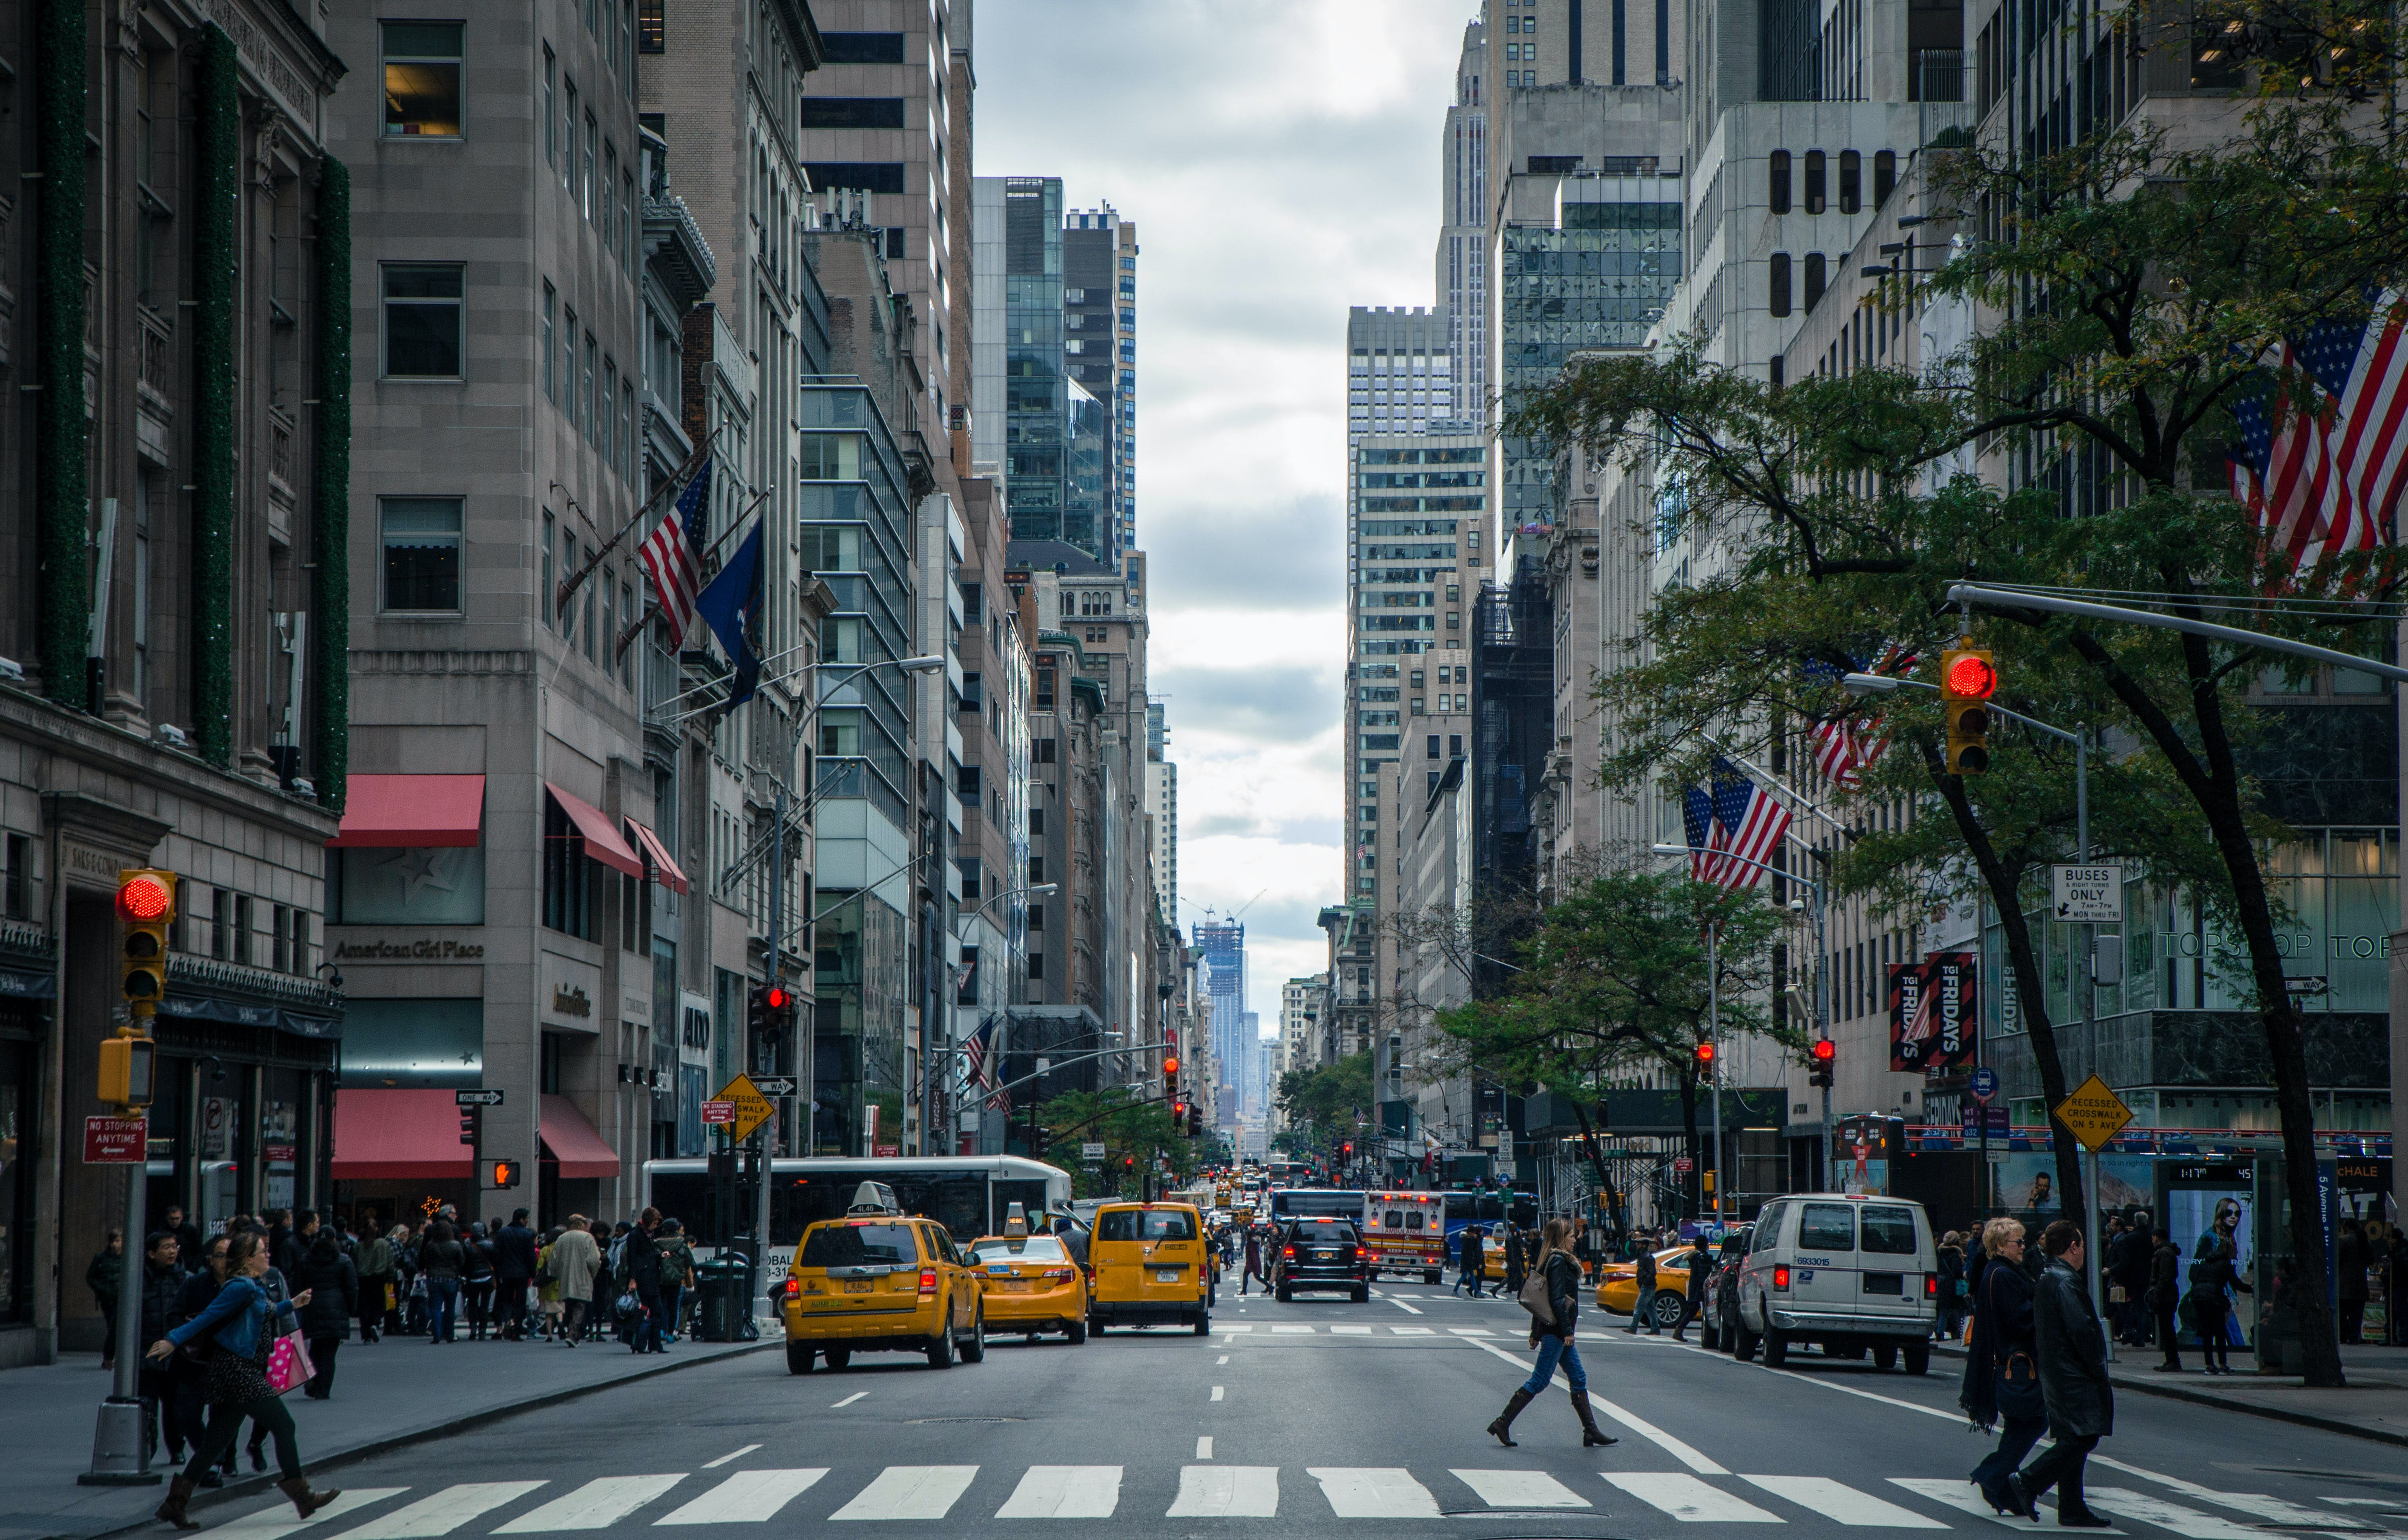

In [19]:
from tensorflow.keras.preprocessing import image


file = 'MobileNet-CNN/test-1.jpeg'

image = predict(file)
display(image)

Flooding


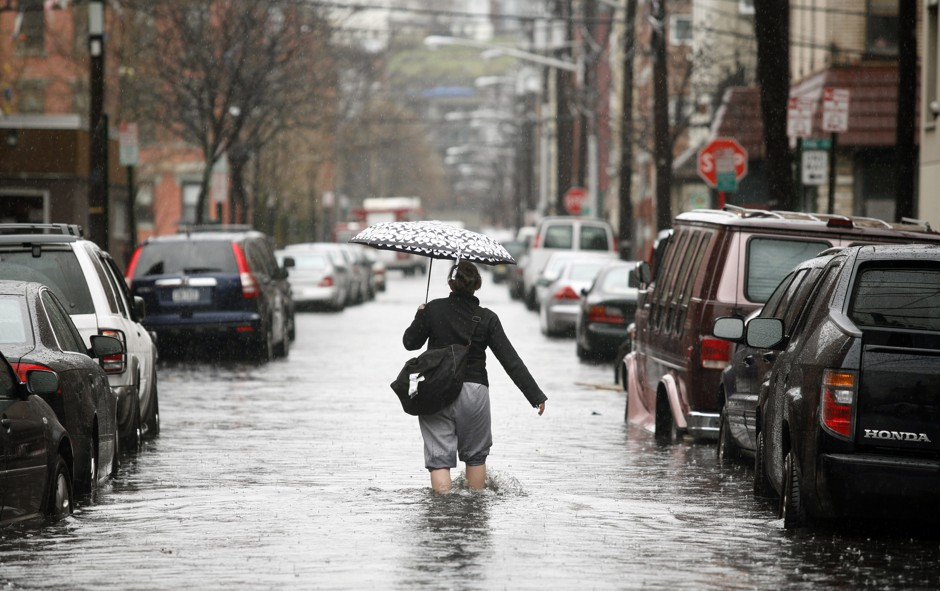

In [20]:
from tensorflow.keras.preprocessing import image


file = 'MobileNet-CNN/test-2.jpg'

image = predict(file)
display(image)

Flooding


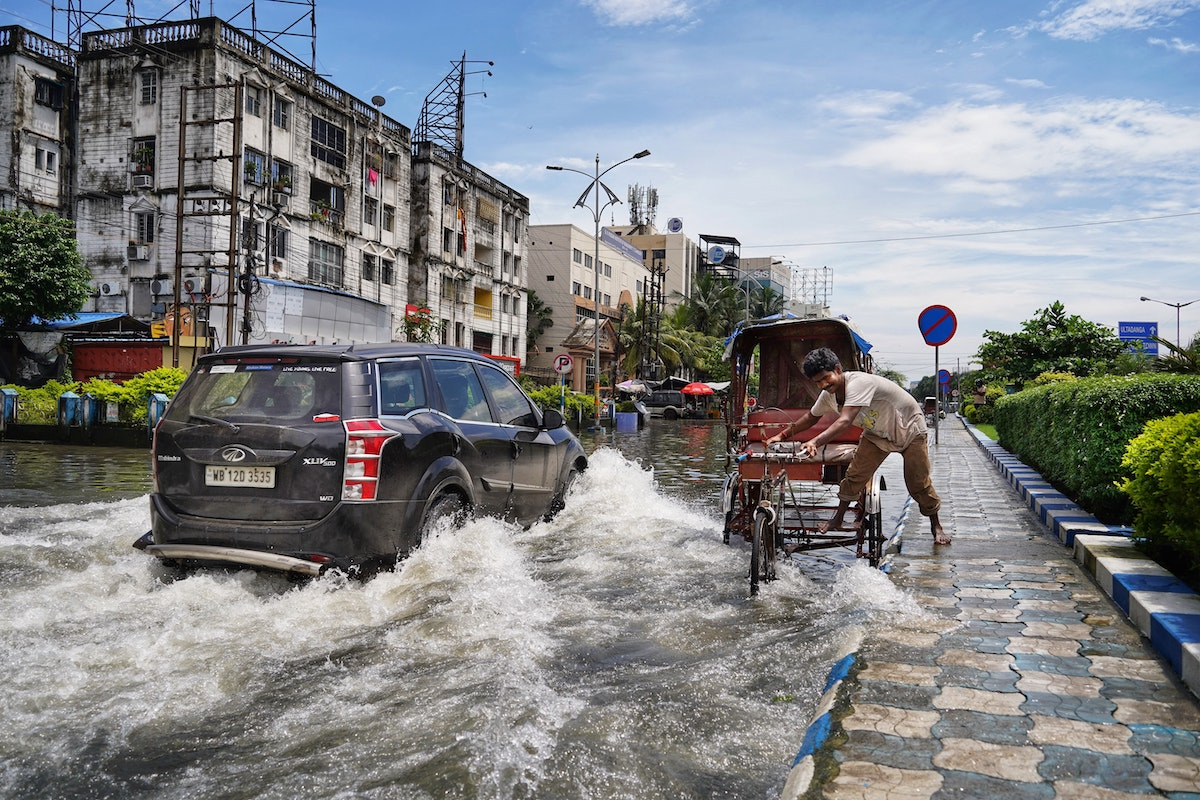

In [21]:
from tensorflow.keras.preprocessing import image


file = 'MobileNet-CNN/test-3.jpg'

image = predict(file)
display(image)

Flooding


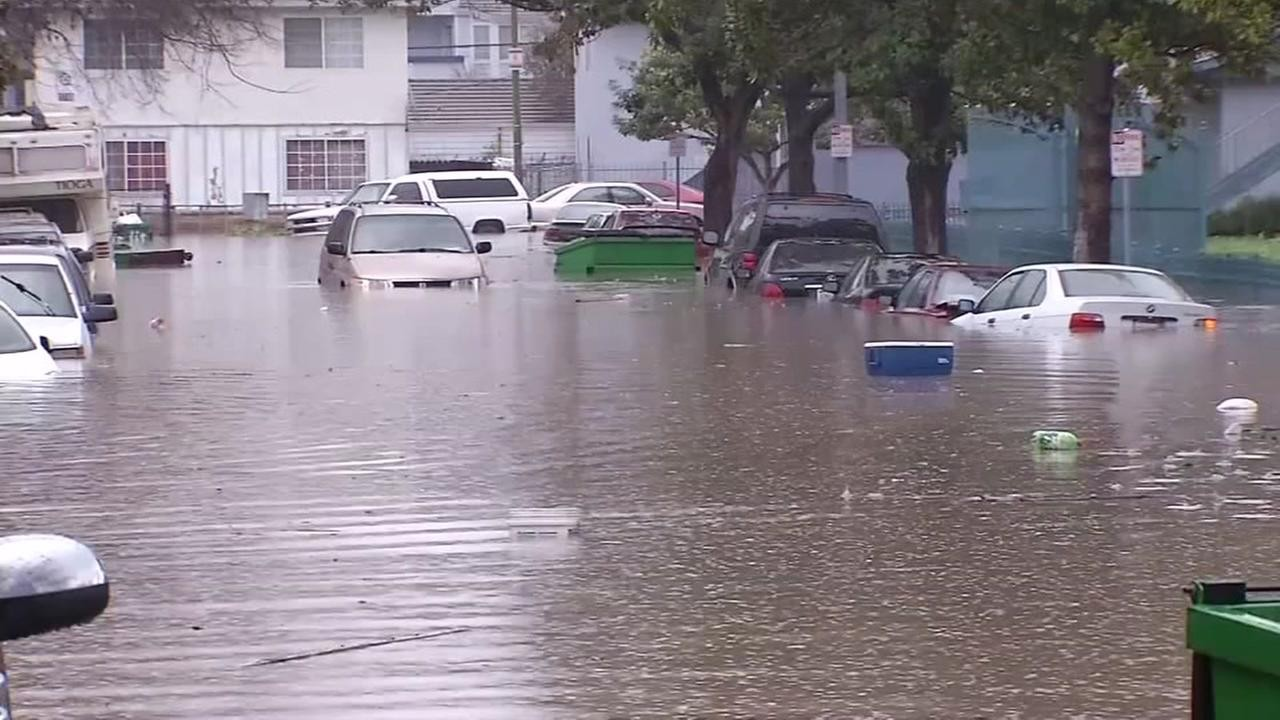

In [22]:
from tensorflow.keras.preprocessing import image


file = 'MobileNet-CNN/test-4.jpeg'

image = predict(file)
display(image)

Flooding


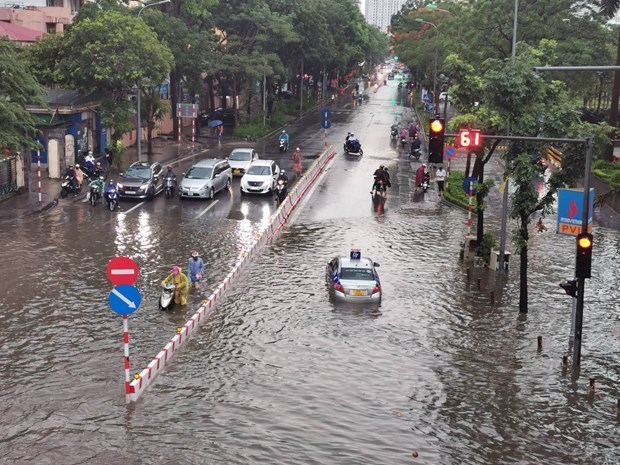

In [23]:
from tensorflow.keras.preprocessing import image


file = 'MobileNet-CNN/test-5.jpg'

image = predict(file)
display(image)

No Flooding


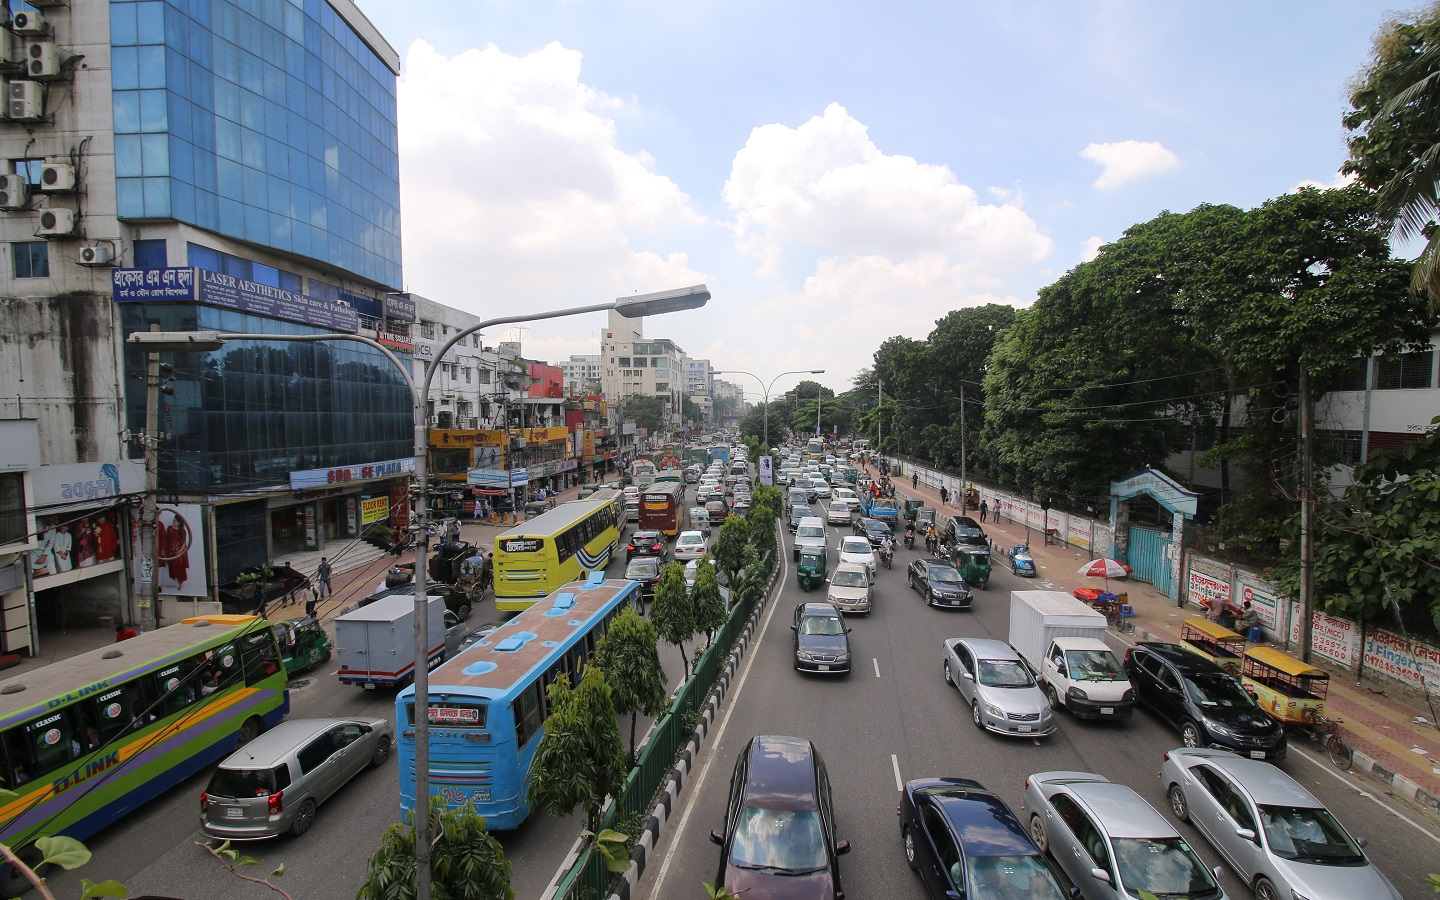

In [24]:
from tensorflow.keras.preprocessing import image


file = 'MobileNet-CNN/test-6.jpg'

image = predict(file)
display(image)

Flooding


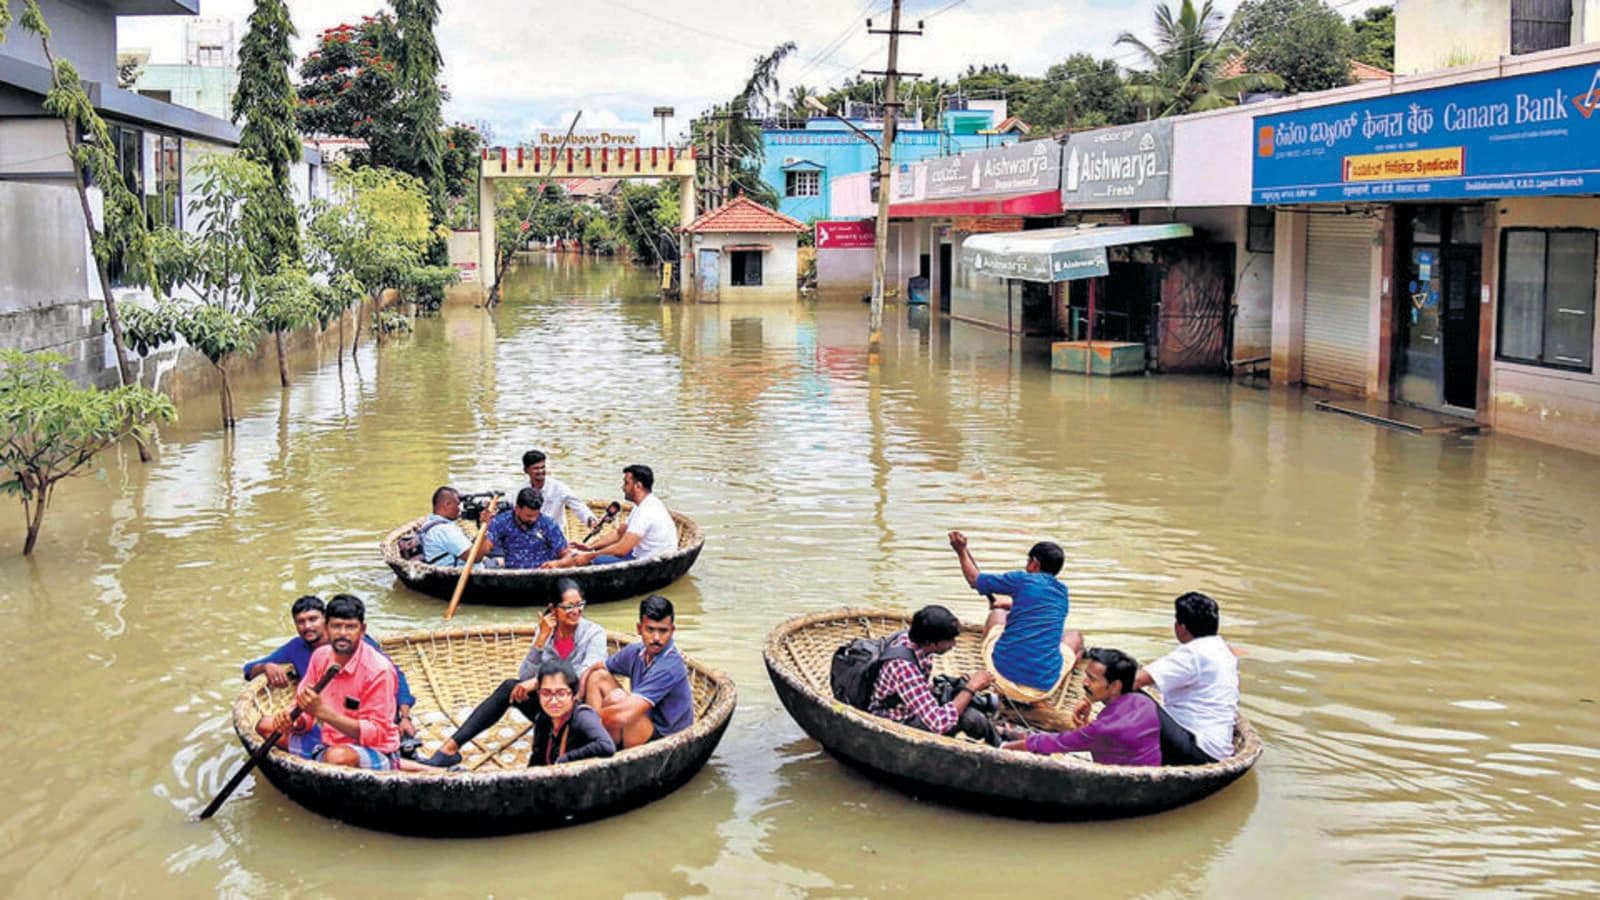

In [25]:
from tensorflow.keras.preprocessing import image


file = 'MobileNet-CNN/test-8.jpg'

image = predict(file)
display(image)

No Flooding


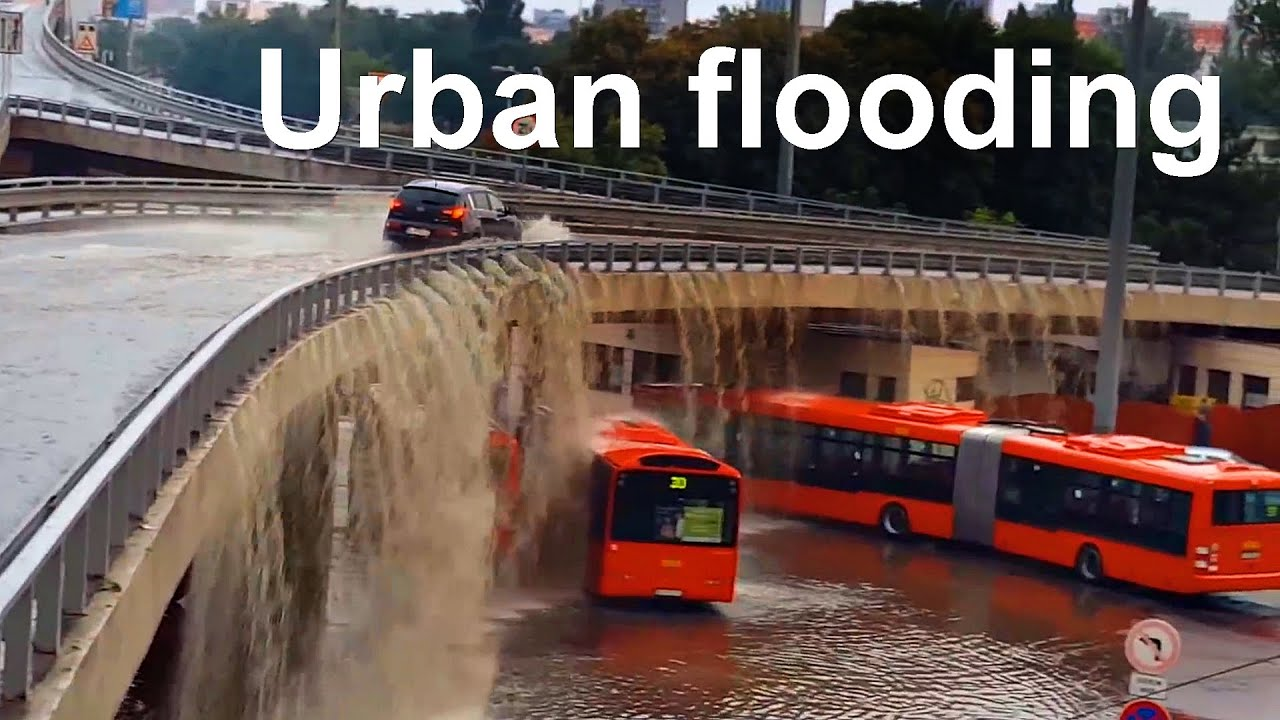

In [26]:
from tensorflow.keras.preprocessing import image


file = 'MobileNet-CNN/test-10.jpg'

image = predict(file)
display(image)

No Flooding


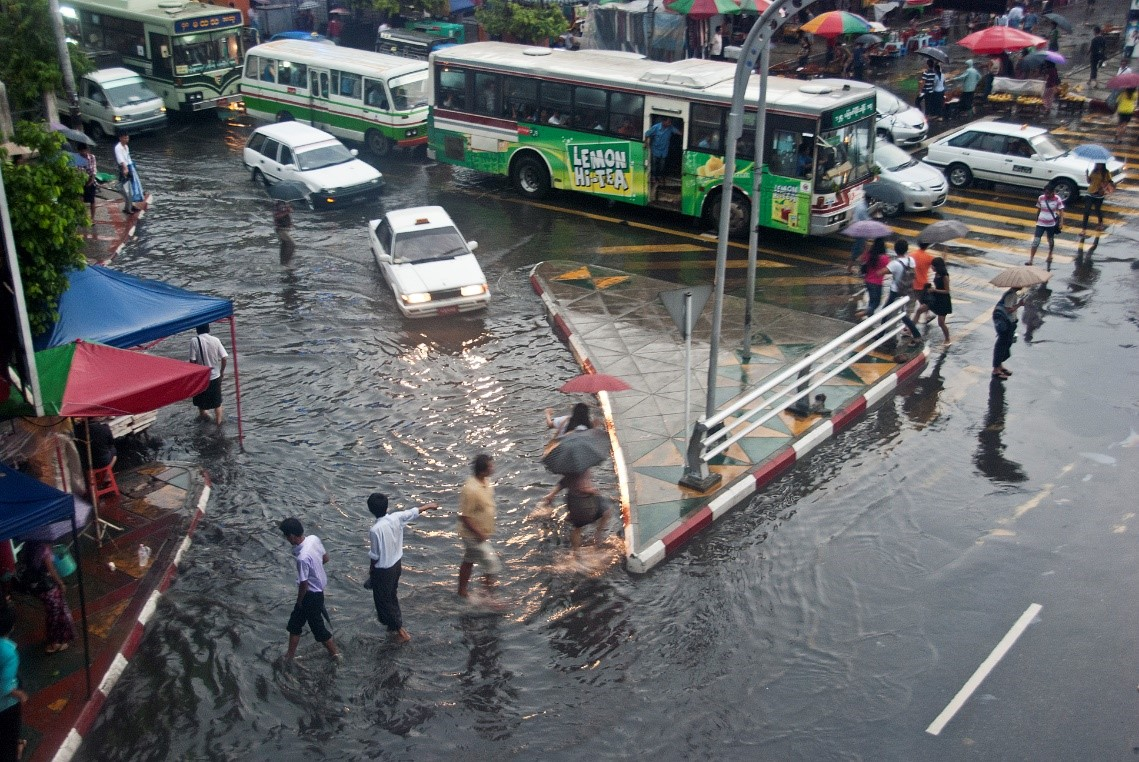

In [27]:
from tensorflow.keras.preprocessing import image


file = 'MobileNet-CNN/test-11.jpg'

image = predict(file)
display(image)

No Flooding


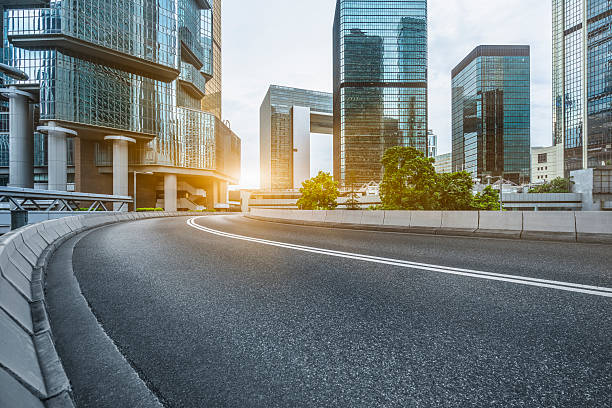

In [28]:
from tensorflow.keras.preprocessing import image


file = 'MobileNet-CNN/test-12.jpg'

image = predict(file)
display(image)

No Flooding


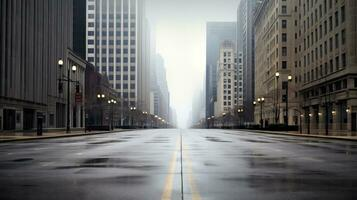

In [29]:
from tensorflow.keras.preprocessing import image


file = 'MobileNet-CNN/test-13.jpg'

image = predict(file)
display(image)

No Flooding


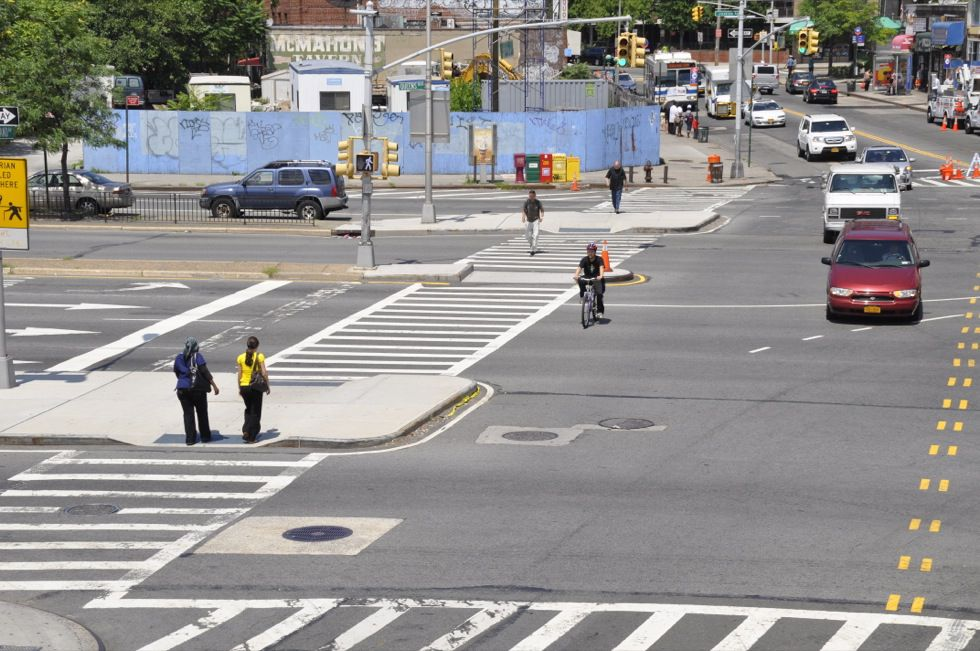

In [30]:
from tensorflow.keras.preprocessing import image


file = 'MobileNet-CNN/test-14.jpg'

image = predict(file)
display(image)

Flooding


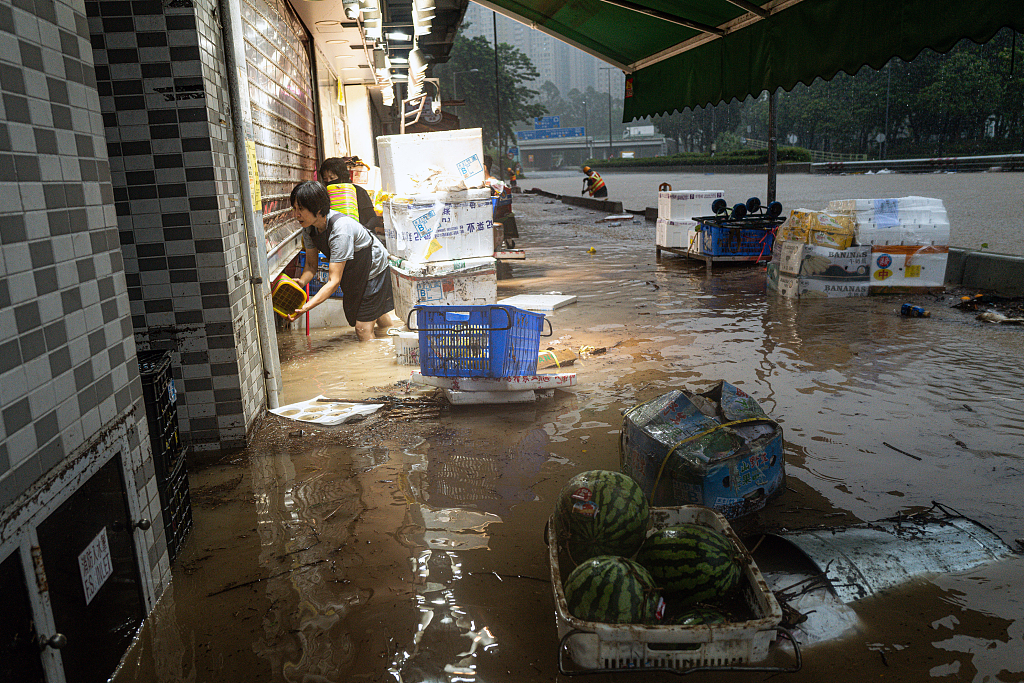

In [31]:
from tensorflow.keras.preprocessing import image


file = 'MobileNet-CNN/test-15.jpeg'

image = predict(file)
display(image)

# VGG16

In [51]:
labels = ['Flooding', 'No Flooding']
train_path = 'MobileNet-CNN/data/train'
valid_path = 'MobileNet-CNN/data/valid'
test_path = 'MobileNet-CNN/data/test'

datagen = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images up to 40 degrees
    width_shift_range=0.2,  # Shift images horizontally by up to 20% of their width
    height_shift_range=0.2,  # Shift images vertically by up to 20% of their height
    shear_range=0.2,  # Randomly shear images
    zoom_range=0.2,  # Randomly zoom images
    horizontal_flip=True,  # Flip images horizontally
    fill_mode='nearest',  # Fill in empty pixels during transformations
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
)

train_batches = datagen.flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 281 images belonging to 2 classes.
Found 67 images belonging to 2 classes.
Found 67 images belonging to 2 classes.


In [52]:
vgg = tf.keras.applications.VGG16(input_shape=(224, 224,3), weights='imagenet', include_top=False)

In [53]:
for layer in vgg.layers:
  layer.trainable = False

In [54]:
x = vgg.output
x = keras.layers.GlobalAveragePooling2D()(x)
output = Dense(units=2, activation='sigmoid')(x)

In [55]:
vmodel = Model(inputs=vgg.input, outputs=output)

In [56]:
vmodel.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


In [57]:
vhist = vmodel.fit(x=train_batches,
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          epochs=12,
          verbose=2
)

Epoch 1/12
29/29 - 9s - loss: 2.4872 - accuracy: 0.5338 - val_loss: 2.2045 - val_accuracy: 0.4627
Epoch 2/12
29/29 - 9s - loss: 1.7425 - accuracy: 0.5623 - val_loss: 2.2046 - val_accuracy: 0.4776
Epoch 3/12
29/29 - 9s - loss: 1.5512 - accuracy: 0.5480 - val_loss: 2.2201 - val_accuracy: 0.4776
Epoch 4/12
29/29 - 9s - loss: 1.3234 - accuracy: 0.6050 - val_loss: 2.2254 - val_accuracy: 0.4925
Epoch 5/12
29/29 - 9s - loss: 1.2602 - accuracy: 0.6477 - val_loss: 2.1981 - val_accuracy: 0.5373
Epoch 6/12
29/29 - 9s - loss: 1.1363 - accuracy: 0.6477 - val_loss: 2.1389 - val_accuracy: 0.5672
Epoch 7/12
29/29 - 9s - loss: 1.0661 - accuracy: 0.6797 - val_loss: 2.0463 - val_accuracy: 0.5672
Epoch 8/12
29/29 - 9s - loss: 1.0270 - accuracy: 0.6726 - val_loss: 1.9486 - val_accuracy: 0.5672
Epoch 9/12
29/29 - 9s - loss: 1.0934 - accuracy: 0.7011 - val_loss: 1.8879 - val_accuracy: 0.5672
Epoch 10/12
29/29 - 9s - loss: 0.8884 - accuracy: 0.7438 - val_loss: 1.8014 - val_accuracy: 0.5970
Epoch 11/12
29/29 -

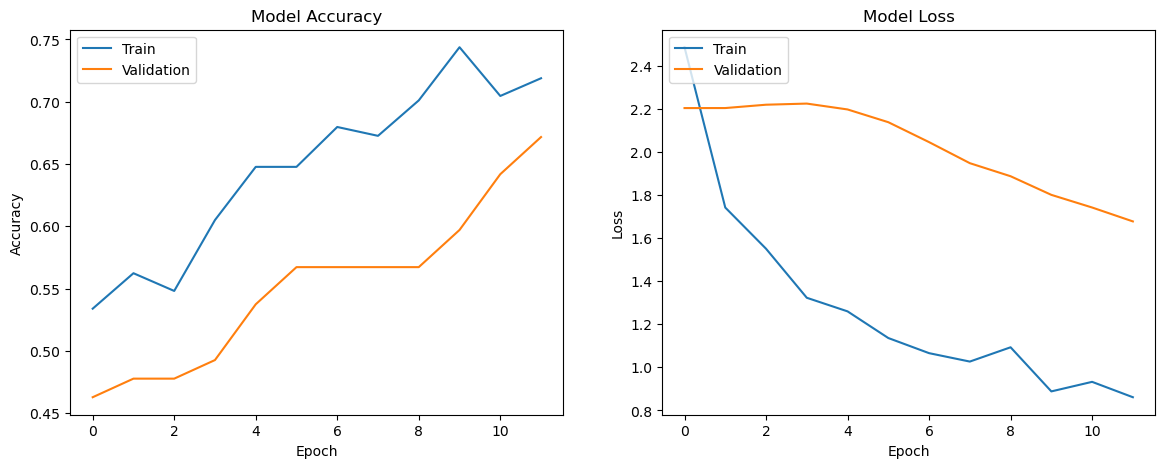

In [58]:
import matplotlib.pyplot as plt

# Fit the model and save the history


# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(vhist.history['accuracy'])
plt.plot(vhist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(vhist.history['loss'])
plt.plot(vhist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [59]:

from sklearn.metrics import f1_score
test_labels = test_batches.classes
predictions = vmodel.predict(x=test_batches, steps=len(test_batches), verbose=0)
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))
precision = precision_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))
recall = recall_score(y_true=test_labels, y_pred=predictions.argmax(axis=1), average='weighted')
f1_score = f1_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))
accuracy = accuracy_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [60]:
print('Precision: ', precision)
print('Recall: ', recall)
print('F1 Score: ', f1_score)
print('Accuracy: ', accuracy)

Precision:  0.5185185185185185
Recall:  0.6567164179104478
F1 Score:  0.5490196078431373
Accuracy:  0.6567164179104478


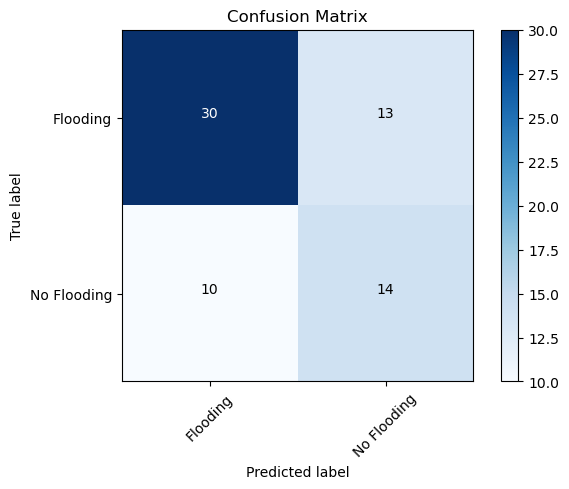

In [61]:
test_batches.class_indices
cm_plot_labels = ['Flooding','No Flooding']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

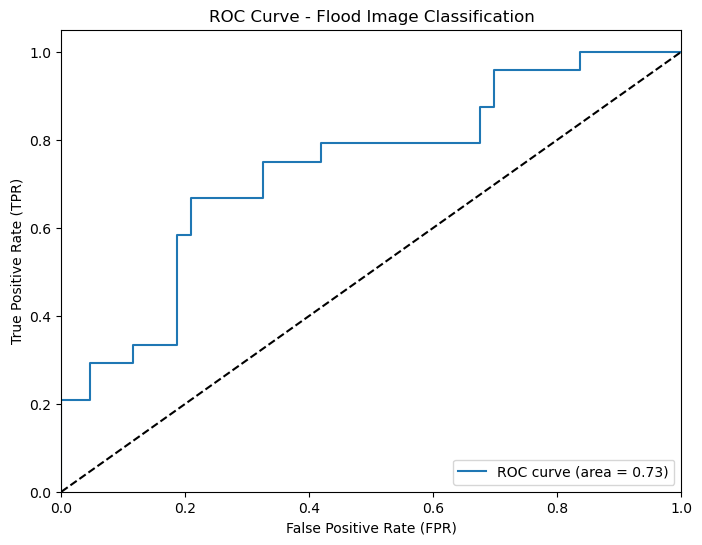

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


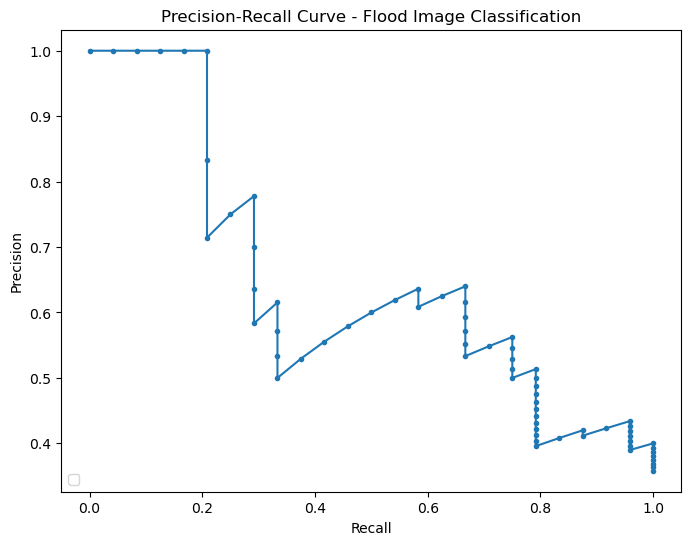

In [62]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Get true labels and predicted probabilities
test_labels = test_batches.classes
predictions = vmodel.predict(x=test_batches, steps=len(test_batches), verbose=0)

# Calculate false positive rate (FPR) and true positive rate (TPR) for ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, predictions[:, 1])

# Calculate Area Under the Curve (AUC) for ROC curve
roc_auc = auc(fpr, tpr)

# Calculate precision and recall for different thresholds in Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(test_labels, predictions[:, 1])

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve - Flood Image Classification')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Flood Image Classification')
plt.legend(loc="lower left")
plt.show()


# ResNet50

In [2]:
labels = ['Flooding', 'No Flooding']
train_path = 'MobileNet-CNN/data/train'
valid_path = 'MobileNet-CNN/data/valid'
test_path = 'MobileNet-CNN/data/test'

datagen = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images up to 40 degrees
    width_shift_range=0.2,  # Shift images horizontally by up to 20% of their width
    height_shift_range=0.2,  # Shift images vertically by up to 20% of their height
    shear_range=0.2,  # Randomly shear images
    zoom_range=0.2,  # Randomly zoom images
    horizontal_flip=True,  # Flip images horizontally
    fill_mode='nearest',  # Fill in empty pixels during transformations
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

train_batches = datagen.flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 281 images belonging to 2 classes.
Found 67 images belonging to 2 classes.
Found 67 images belonging to 2 classes.


In [3]:
res = tf.keras.applications.ResNet50(input_shape=(224, 224,3), weights='imagenet', include_top=False)

In [4]:
for layer in res.layers:
  layer.trainable = False

In [5]:
x = res.output
x = keras.layers.GlobalAveragePooling2D()(x)
output = Dense(units=2, activation='sigmoid')(x)

In [6]:
rmodel = Model(inputs=res.input, outputs=output)

In [7]:
rmodel.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])


In [8]:
rhist = rmodel.fit(x=train_batches,
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          epochs=12,
          verbose=2
)

Epoch 1/12
29/29 - 7s - loss: 0.7029 - accuracy: 0.5943 - val_loss: 0.6918 - val_accuracy: 0.6866
Epoch 2/12
29/29 - 6s - loss: 0.6990 - accuracy: 0.6192 - val_loss: 0.6757 - val_accuracy: 0.6866
Epoch 3/12
29/29 - 6s - loss: 0.6468 - accuracy: 0.6904 - val_loss: 0.6615 - val_accuracy: 0.6866
Epoch 4/12
29/29 - 6s - loss: 0.6622 - accuracy: 0.6726 - val_loss: 0.6496 - val_accuracy: 0.6866
Epoch 5/12
29/29 - 6s - loss: 0.6360 - accuracy: 0.6797 - val_loss: 0.6380 - val_accuracy: 0.7015
Epoch 6/12
29/29 - 6s - loss: 0.6317 - accuracy: 0.6868 - val_loss: 0.6269 - val_accuracy: 0.7313
Epoch 7/12
29/29 - 6s - loss: 0.6246 - accuracy: 0.6904 - val_loss: 0.6169 - val_accuracy: 0.7463
Epoch 8/12
29/29 - 6s - loss: 0.6073 - accuracy: 0.7331 - val_loss: 0.6076 - val_accuracy: 0.7463
Epoch 9/12
29/29 - 6s - loss: 0.6046 - accuracy: 0.7224 - val_loss: 0.5986 - val_accuracy: 0.7612
Epoch 10/12
29/29 - 6s - loss: 0.5877 - accuracy: 0.7331 - val_loss: 0.5891 - val_accuracy: 0.7612
Epoch 11/12
29/29 -

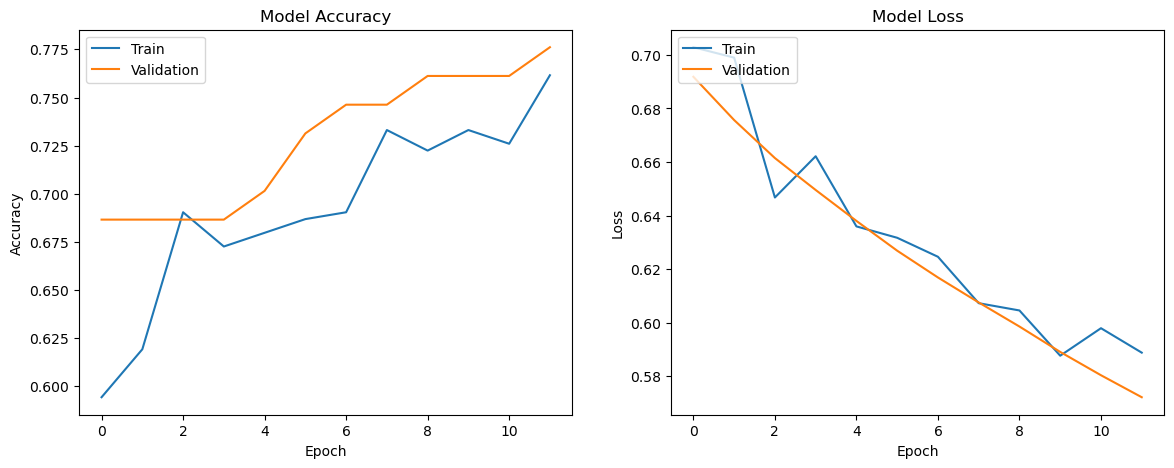

In [9]:
import matplotlib.pyplot as plt

# Fit the model and save the history


# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(rhist.history['accuracy'])
plt.plot(rhist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(rhist.history['loss'])
plt.plot(rhist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [10]:
from sklearn.metrics import f1_score

test_labels = test_batches.classes
predictions = rmodel.predict(x=test_batches, steps=len(test_batches), verbose=0)
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))
precision = precision_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))
recall = recall_score(y_true=test_labels, y_pred=predictions.argmax(axis=1), average='weighted')
f1_score = f1_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))
accuracy = accuracy_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [11]:
print('Precision: ', precision)
print('Recall: ', recall)
print('F1 Score: ', f1_score)
print('Accuracy: ', accuracy)

Precision:  0.8571428571428571
Recall:  0.7910447761194029
F1 Score:  0.631578947368421
Accuracy:  0.7910447761194029


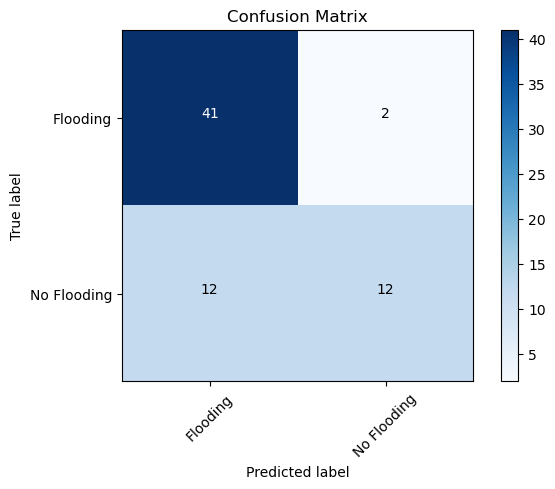

In [12]:
test_batches.class_indices
cm_plot_labels = ['Flooding','No Flooding']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

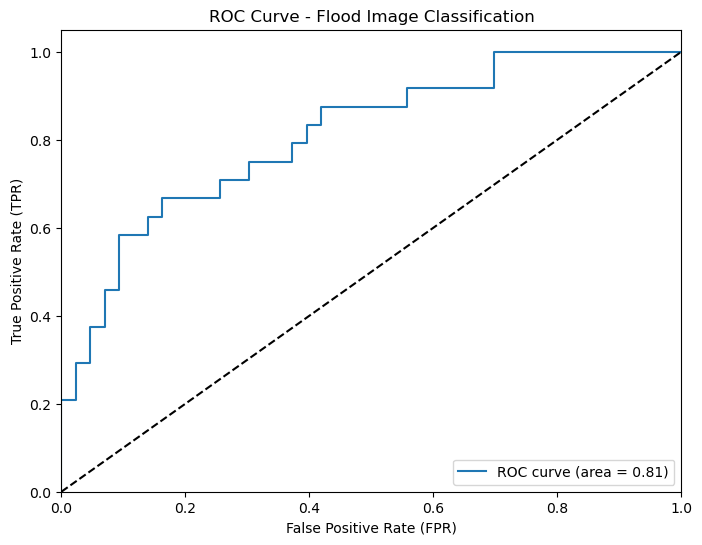

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


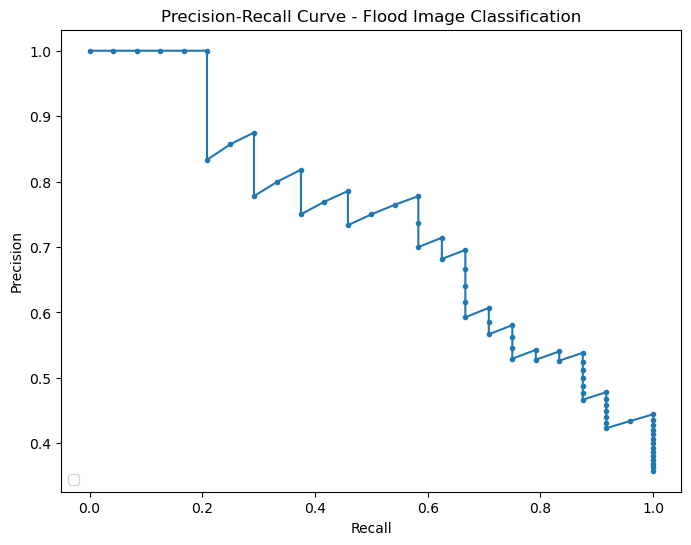

In [13]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Get true labels and predicted probabilities
test_labels = test_batches.classes
predictions = rmodel.predict(x=test_batches, steps=len(test_batches), verbose=0)

# Calculate false positive rate (FPR) and true positive rate (TPR) for ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, predictions[:, 1])

# Calculate Area Under the Curve (AUC) for ROC curve
roc_auc = auc(fpr, tpr)

# Calculate precision and recall for different thresholds in Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(test_labels, predictions[:, 1])

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve - Flood Image Classification')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Flood Image Classification')
plt.legend(loc="lower left")
plt.show()


# MobileNet

In [3]:
labels = ['Flooding', 'No Flooding']
train_path = 'MobileNet-CNN/data/train'
valid_path = 'MobileNet-CNN/data/valid'
test_path = 'MobileNet-CNN/data/test'

datagen = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images up to 40 degrees
    width_shift_range=0.2,  # Shift images horizontally by up to 20% of their width
    height_shift_range=0.2,  # Shift images vertically by up to 20% of their height
    shear_range=0.2,  # Randomly shear images
    zoom_range=0.2,  # Randomly zoom images
    horizontal_flip=True,  # Flip images horizontally
    fill_mode='nearest',  # Fill in empty pixels during transformations
    preprocessing_function=tf.keras.applications.mobilenet.preprocess_input
)

train_batches = datagen.flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 281 images belonging to 2 classes.
Found 67 images belonging to 2 classes.
Found 67 images belonging to 2 classes.


In [4]:
mobile = tf.keras.applications.mobilenet.MobileNet(input_shape=(224, 224,3), weights='imagenet', include_top=False)

In [5]:
for layer in mobile.layers:
  layer.trainable = False

In [6]:
x = mobile.output
x = keras.layers.GlobalAveragePooling2D()(x)
output = Dense(units=2, activation='sigmoid')(x)

In [7]:
mmodel = Model(inputs=mobile.input, outputs=output)

In [8]:
mmodel.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


In [9]:
mhist = mmodel.fit(x=train_batches,
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          epochs=12,
          verbose=2
)

Epoch 1/12
29/29 - 4s - loss: 0.8502 - accuracy: 0.5018 - val_loss: 0.7276 - val_accuracy: 0.5970
Epoch 2/12
29/29 - 4s - loss: 0.7061 - accuracy: 0.6228 - val_loss: 0.6951 - val_accuracy: 0.6567
Epoch 3/12
29/29 - 3s - loss: 0.6753 - accuracy: 0.6406 - val_loss: 0.6479 - val_accuracy: 0.7015
Epoch 4/12
29/29 - 4s - loss: 0.6378 - accuracy: 0.6655 - val_loss: 0.6012 - val_accuracy: 0.7463
Epoch 5/12
29/29 - 3s - loss: 0.5761 - accuracy: 0.7402 - val_loss: 0.5640 - val_accuracy: 0.8060
Epoch 6/12
29/29 - 3s - loss: 0.5704 - accuracy: 0.7295 - val_loss: 0.5301 - val_accuracy: 0.8060
Epoch 7/12
29/29 - 3s - loss: 0.5256 - accuracy: 0.7900 - val_loss: 0.4963 - val_accuracy: 0.8209
Epoch 8/12
29/29 - 3s - loss: 0.4930 - accuracy: 0.8221 - val_loss: 0.4705 - val_accuracy: 0.8657
Epoch 9/12
29/29 - 4s - loss: 0.4764 - accuracy: 0.8577 - val_loss: 0.4472 - val_accuracy: 0.9104
Epoch 10/12
29/29 - 3s - loss: 0.4352 - accuracy: 0.8897 - val_loss: 0.4203 - val_accuracy: 0.9254
Epoch 11/12
29/29 -

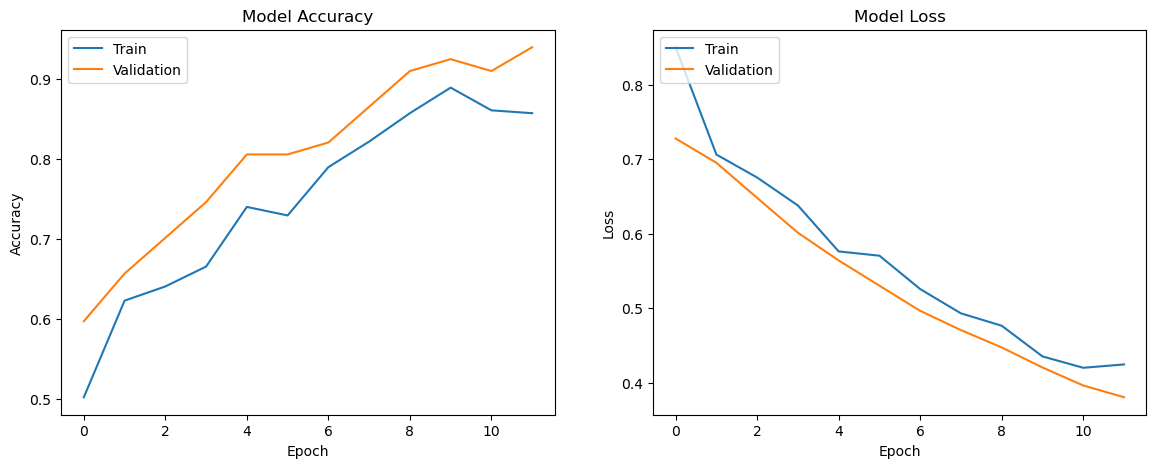

In [10]:
import matplotlib.pyplot as plt

# Fit the model and save the history


# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(mhist.history['accuracy'])
plt.plot(mhist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(mhist.history['loss'])
plt.plot(mhist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [11]:
from sklearn.metrics import f1_score

test_labels = test_batches.classes
predictions = mmodel.predict(x=test_batches, steps=len(test_batches), verbose=0)
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))
precision = precision_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))
recall = recall_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))
f1_score = f1_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))
accuracy = accuracy_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [12]:
print('Precision: ', precision)
print('Recall: ', recall)
print('F1 Score: ', f1_score)
print('Accuracy: ', accuracy)

Precision:  0.9130434782608695
Recall:  0.875
F1 Score:  0.8936170212765957
Accuracy:  0.9253731343283582


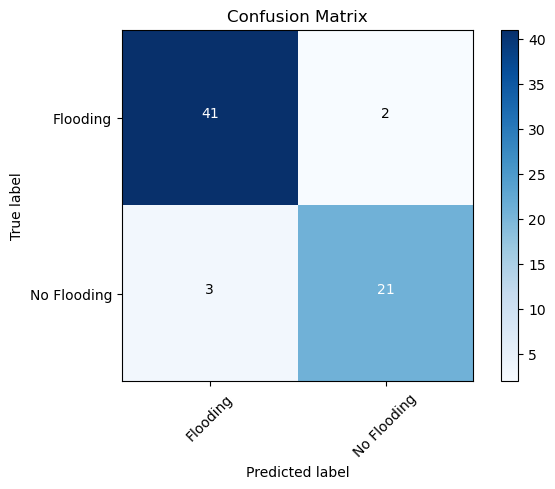

In [13]:
test_batches.class_indices
cm_plot_labels = ['Flooding','No Flooding']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

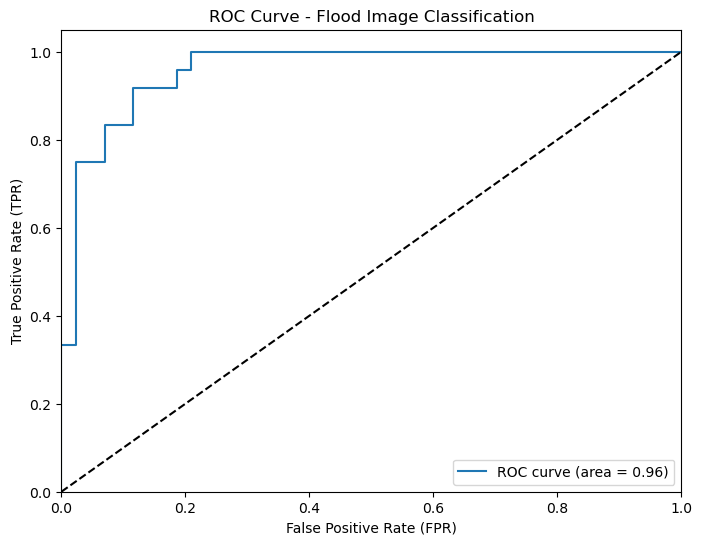

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


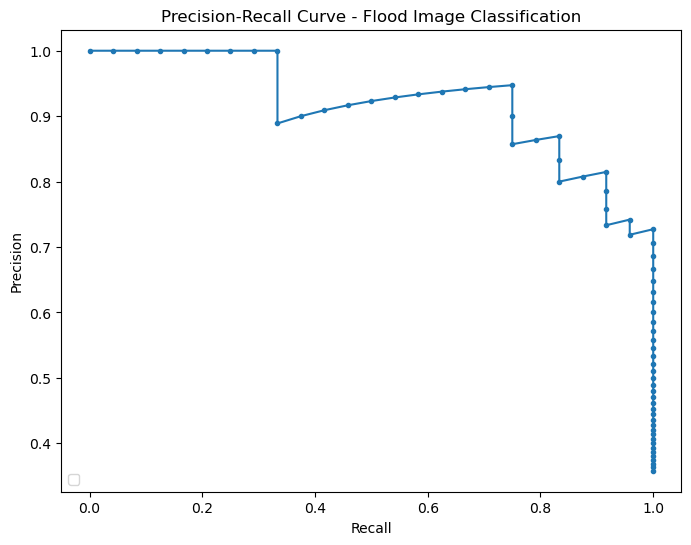

In [14]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Get true labels and predicted probabilities
test_labels = test_batches.classes
predictions = mmodel.predict(x=test_batches, steps=len(test_batches), verbose=0)

# Calculate false positive rate (FPR) and true positive rate (TPR) for ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, predictions[:, 1])

# Calculate Area Under the Curve (AUC) for ROC curve
roc_auc = auc(fpr, tpr)

# Calculate precision and recall for different thresholds in Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(test_labels, predictions[:, 1])

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve - Flood Image Classification')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Flood Image Classification')
plt.legend(loc="lower left")
plt.show()


#Result

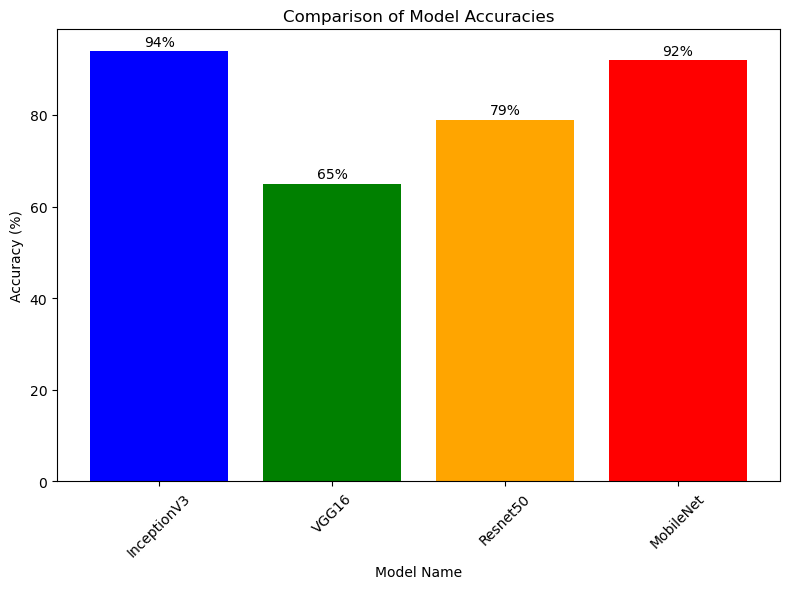

In [1]:
import matplotlib.pyplot as plt

# Define model names and accuracies
models = ["InceptionV3", "VGG16", "Resnet50", "MobileNet"]
accuracies = [94, 65, 79, 92]

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'orange', 'red'])
plt.xlabel("Model Name")
plt.ylabel("Accuracy (%)")
plt.title("Comparison of Model Accuracies")

# Add data labels above the bars
for i, value in enumerate(accuracies):
    plt.text(i, value + 0.5, str(value) + "%", ha='center', va='bottom')

# Display the chart
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


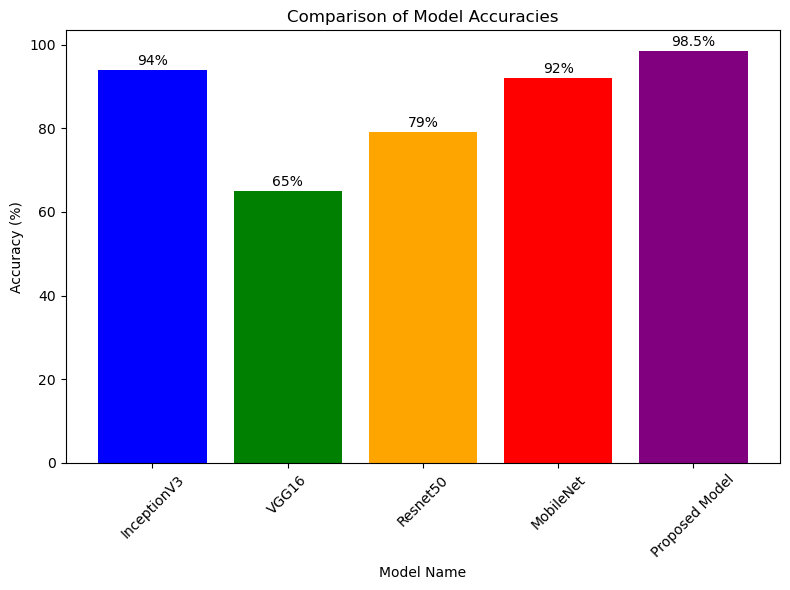

In [1]:
import matplotlib.pyplot as plt

# Define model names and accuracies
models = ["InceptionV3", "VGG16", "Resnet50", "MobileNet", "Proposed Model"]
accuracies = [94, 65, 79, 92, 98.5]

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'orange', 'red', 'purple'])
plt.xlabel("Model Name")
plt.ylabel("Accuracy (%)")
plt.title("Comparison of Model Accuracies")

# Add data labels above the bars
for i, value in enumerate(accuracies):
    plt.text(i, value + 0.5, str(value) + "%", ha='center', va='bottom')

# Display the chart
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()
